# Lesson 14.1 数据归一化与Batch Normalization理论基础

- 传统机器学习，数据归一化可能会降低模型的可解释性
- 在深度学习中数据归一化将能够有效确保模型各层学习的有效性，缓解梯度消失和梯度爆炸的情况发生，并且深度学习并不要求可解释性

## 一、经典机器学习的归一化算法

- 0-1标准化（Max-Min Normalization）
- Z-Score标准化

#### 1.1 0-1标准化方法

$${x}_{normalization}=\frac{x-Min}{Max-Min}$$


In [2]:
t = torch.arange(12).reshape(6, 2).float()
t



tensor([[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.],
        [ 8.,  9.],
        [10., 11.]])

In [3]:
t.max(0)  # 返回每一列的最大值和最大值的索引

t.max(1)  # 每一行的最大值和最大值索引

t_max = t.max(0)[0]
t_max

t_min = t.min(0)[0]           # 提取每列最小值
t_min

torch.return_types.max(
values=tensor([10., 11.]),
indices=tensor([5, 5]))

torch.return_types.max(
values=tensor([ 1.,  3.,  5.,  7.,  9., 11.]),
indices=tensor([1, 1, 1, 1, 1, 1]))

tensor([10., 11.])

tensor([0., 1.])

In [4]:
(t - t_min) / (t_max - t_min)  # 计算0-1标准化后结果

tensor([[0.0000, 0.0000],
        [0.2000, 0.2000],
        [0.4000, 0.4000],
        [0.6000, 0.6000],
        [0.8000, 0.8000],
        [1.0000, 1.0000]])

不过在深度学习领域，我们更希望输入模型的数据是Zero-Centered Data，此时Z-Score标准化会更加合适。

#### 1.2 Z-Score标准化

Z-score标准化利用原始数据的均值（mean）和标准差（standard deviation）进行数据的标准化。同样是逐列进行操作，每一条数据都减去当前列的均值再除以当前列的标准差。很明显，通过这种方法处理之后的数据是典型的Zero-Centered Data，并且如果原数据服从正态分布。

$${x}_{normalization}=\frac{x-\mu }{\sigma }$$

In [5]:
t.mean(0)  # 每列的均值

t.std(0)  # 每列的方差

(t- t.mean(0)) / t.std(0)


tensor([5., 6.])

tensor([3.7417, 3.7417])

tensor([[-1.3363, -1.3363],
        [-0.8018, -0.8018],
        [-0.2673, -0.2673],
        [ 0.2673,  0.2673],
        [ 0.8018,  0.8018],
        [ 1.3363,  1.3363]])

In [6]:
#————————————————————————————Z-Score封装为函数————————————————————————————

def Z_ScoreNormalization(data):
    stdDf = data.std(0)
    meanDf = data.mean(0)
    normSet = (data - meanDf) / stdDf
    return normSet 

# 一种更加严谨的做法，是在分母项、也就是标准差上加上一个非常小的常数$\mu$，
# 从而使得分母恒大于0。

### 2.经典机器学习归一化算法在深度学习中的实践

- 在训练集上训练，测试集上测试
  
首先，标签是否标准化对建模没有影响，因此一般我们不会对标签进行标准化   

其次，在实际模型训练过程中，由于数据集要划分成训练集和测试集，因此一般来说我们会在训练集的特征中逐行计算其均值和标准差，然后进行模型训练。
当输入测试集进行测试时，**我们会将在训练集上计算得出的每一列的均值和标准差带入测试集并对测试集特征进行标准化**，然后再带入进行模型测试。

值得注意的是，此时进行标准化时涉及到的每一列的均值和方差也相当于是模型参数，必须从训练集上得出，不能借助测试集的数据。


In [7]:
#————————————————————————————Z-Score建模实验 - 数据准备————————————————————————————

# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1], bias=False, deg=2)
features_norm = Z_ScoreNormalization(features)
# 对于所有的数据都进行了归一化，不太严谨，应该是对训练集中的数据归一化

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)
train_loader_norm, test_loader = split_loader(features_norm, labels)

In [8]:
#————————————————————————————Z-Score建模实验 -训练模型————————————————————————————
# 设置随机数种子
torch.manual_seed(24)  


# 关键参数
lr = 0.03
num_epochs = 40


# 实例化模型
sigmoid_model3 = Sigmoid_class3() 
sigmoid_model3_norm = Sigmoid_class3()  


# 进行XavierCAM参数初始化
for m in sigmoid_model3.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        
for m in sigmoid_model3_norm.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


# sigmoid_model3模型训练
train_l, test_l = model_train_test(sigmoid_model3, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

# sigmoid_model3_norm模型训练 - 数据的特征Z-score化
train_l_norm, test_l_norm = model_train_test(sigmoid_model3_norm, 
                                             train_loader_norm,
                                             test_loader,
                                             num_epochs = num_epochs, 
                                             criterion = nn.MSELoss(), 
                                             optimizer = optim.SGD, 
                                             lr = lr, 
                                             cla = False, 
                                             eva = mse_cal)



Parameter containing:
tensor([[ 0.8590, -0.6975],
        [ 0.1762, -0.7295],
        [ 0.5904,  0.3405],
        [-0.7281, -0.0867]], requires_grad=True)

Parameter containing:
tensor([[-0.5633,  0.1303, -0.5045,  0.3393],
        [-0.7823,  0.2525,  0.7264,  0.5470],
        [ 0.7246, -0.0357, -0.6253,  0.1108],
        [-0.3299, -0.5521,  0.5269,  0.1061]], requires_grad=True)

Parameter containing:
tensor([[ 0.4386,  0.8341,  0.1352, -0.8077],
        [ 0.2441,  0.4123,  0.0232, -0.7393],
        [ 0.8236, -0.8110,  0.6018, -0.0395],
        [ 0.6284, -0.7337,  0.8656,  0.2915]], requires_grad=True)

Parameter containing:
tensor([[0.9703, 0.6656, 0.8244, 0.3487]], requires_grad=True)

Parameter containing:
tensor([[-0.2945,  0.9237],
        [ 0.7596, -0.6387],
        [-0.0023, -0.3001],
        [-0.9573,  0.0271]], requires_grad=True)

Parameter containing:
tensor([[-0.5126, -0.1948, -0.2230,  0.7317],
        [ 0.3355, -0.7767,  0.4933,  0.5650],
        [ 0.3391,  0.3513,  0.3385,  0.0232],
        [-0.7911, -0.4265,  0.5541,  0.2841]], requires_grad=True)

Parameter containing:
tensor([[ 0.6846,  0.2079,  0.8334, -0.3973],
        [-0.4116,  0.3072, -0.4335,  0.3472],
        [ 0.0940, -0.3414,  0.2058,  0.8155],
        [ 0.4660, -0.8182,  0.3571,  0.5147]], requires_grad=True)

Parameter containing:
tensor([[ 0.7612, -0.2644,  0.8887,  0.8696]], requires_grad=True)

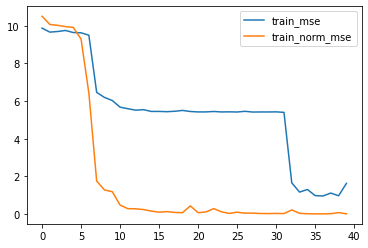

In [9]:
plt.plot(list(range(num_epochs)), train_l, label='train_mse')
plt.plot(list(range(num_epochs)), train_l_norm, label='train_norm_mse')
plt.legend(loc = 1)

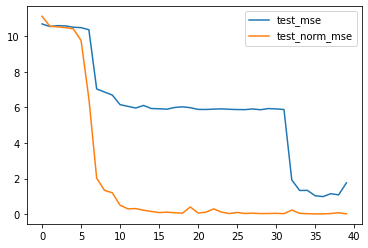

In [10]:
plt.plot(list(range(num_epochs)), test_l, label='test_mse')
plt.plot(list(range(num_epochs)), test_l_norm, label='test_norm_mse')
plt.legend(loc = 1)

# 数据归一化后，模型的训练效果较好

-  一般来说，Xavier初始化和数据归一化不同时使用

In [11]:
#——————————————————验证归一化是否有助于各层梯度保持平稳————————————————————
# 设置随机数种子
torch.manual_seed(24)  


# 关键参数
lr = 0.03
num_epochs = 5


# 实例化模型
sigmoid_model3 = Sigmoid_class3() 
sigmoid_model3_norm = Sigmoid_class3()  


# 进行Xavier初始化
for m in sigmoid_model3.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        
for m in sigmoid_model3_norm.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


# sigmoid_model2模型训练
train_l, test_l = model_train_test(sigmoid_model3, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

# sigmoid_model2_norm模型训练
train_l_norm, test_l_norm = model_train_test(sigmoid_model3_norm, 
                                             train_loader_norm,
                                             test_loader,
                                             num_epochs = num_epochs, 
                                             criterion = nn.MSELoss(), 
                                             optimizer = optim.SGD, 
                                             lr = lr, 
                                             cla = False, 
                                             eva = mse_cal)

Parameter containing:
tensor([[ 0.8590, -0.6975],
        [ 0.1762, -0.7295],
        [ 0.5904,  0.3405],
        [-0.7281, -0.0867]], requires_grad=True)

Parameter containing:
tensor([[-0.5633,  0.1303, -0.5045,  0.3393],
        [-0.7823,  0.2525,  0.7264,  0.5470],
        [ 0.7246, -0.0357, -0.6253,  0.1108],
        [-0.3299, -0.5521,  0.5269,  0.1061]], requires_grad=True)

Parameter containing:
tensor([[ 0.4386,  0.8341,  0.1352, -0.8077],
        [ 0.2441,  0.4123,  0.0232, -0.7393],
        [ 0.8236, -0.8110,  0.6018, -0.0395],
        [ 0.6284, -0.7337,  0.8656,  0.2915]], requires_grad=True)

Parameter containing:
tensor([[0.9703, 0.6656, 0.8244, 0.3487]], requires_grad=True)

Parameter containing:
tensor([[-0.2945,  0.9237],
        [ 0.7596, -0.6387],
        [-0.0023, -0.3001],
        [-0.9573,  0.0271]], requires_grad=True)

Parameter containing:
tensor([[-0.5126, -0.1948, -0.2230,  0.7317],
        [ 0.3355, -0.7767,  0.4933,  0.5650],
        [ 0.3391,  0.3513,  0.3385,  0.0232],
        [-0.7911, -0.4265,  0.5541,  0.2841]], requires_grad=True)

Parameter containing:
tensor([[ 0.6846,  0.2079,  0.8334, -0.3973],
        [-0.4116,  0.3072, -0.4335,  0.3472],
        [ 0.0940, -0.3414,  0.2058,  0.8155],
        [ 0.4660, -0.8182,  0.3571,  0.5147]], requires_grad=True)

Parameter containing:
tensor([[ 0.7612, -0.2644,  0.8887,  0.8696]], requires_grad=True)

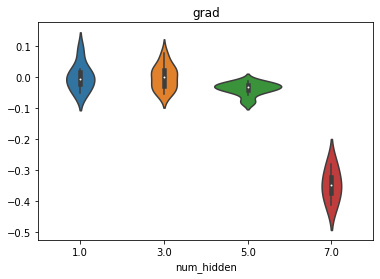

In [12]:
weights_vp(sigmoid_model3, att="grad")


# 梯度分布不均衡

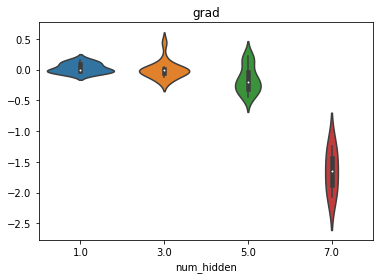

In [13]:
weights_vp(sigmoid_model3_norm, att="grad")

# 按理来说，应该梯度更加平稳，不知道为什么这里梯度变化更加剧烈
# 第四层的梯度爆炸更加明显

&emsp;&emsp;由此能看出，使用归一化后的数据进行建模的模型，前几轮迭代时梯度相对平稳。

我们知道，当各层梯度更加均衡时模型学习能力更强，进而能够加快模型收敛速度，甚至提升模型准确率。因此我们也可以推断，归一化是通过维持梯度平稳来加快收敛速度、提升模型准确率的。

### 3.Z-Score数据归一化的局限

#### 3.1 Zero-Centered特性消失

由于是对于“初始值”的修改，因此也会存在随着迭代次数增加就逐渐破坏了Zero-Centered Data这一条件的问题。  
并且，随着参数和输入数据都回到不可控状态，各层的梯度又将回到不可控的状态，而所谓的控制梯度平稳性也将无从谈起。

例如，我们尝试创建相对梯度容易不平稳的tanh激活函数模型，查看迭代5轮和40轮时各层梯度变化情况

In [14]:
# 设置随机数种子
torch.manual_seed(24)  

# 学习率
lr = 0.03


# 实例化模型
tanh_model2_norm1 = tanh_class2()  
tanh_model2_norm2 = tanh_class2()  


# 进行Xavier初始化
for m in tanh_model2_norm1.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        
for m in tanh_model2_norm2.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


# sigmoid_model2模型训练
train_l, test_l = model_train_test(tanh_model2_norm1, 
                                   train_loader_norm,
                                   test_loader,
                                   num_epochs = 5, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

# sigmoid_model2_norm模型训练
train_l_norm, test_l_norm = model_train_test(tanh_model2_norm2, 
                                             train_loader_norm,
                                             test_loader,
                                             num_epochs = 40, 
                                             criterion = nn.MSELoss(), 
                                             optimizer = optim.SGD, 
                                             lr = lr, 
                                             cla = False, 
                                             eva = mse_cal)

Parameter containing:
tensor([[ 0.2847,  0.4558],
        [ 0.1465, -0.3580],
        [-0.3710, -0.0826],
        [ 0.9358,  0.5741]], requires_grad=True)

Parameter containing:
tensor([[ 0.5889, -0.3163,  0.2033, -0.5345],
        [-0.1101, -0.4292,  0.3611,  0.4440],
        [ 0.1075,  0.6876, -0.8603,  0.3756],
        [ 0.4682,  0.7871,  0.1877, -0.7922]], requires_grad=True)

Parameter containing:
tensor([[ 0.7348, -0.0581,  0.3638, -0.7409]], requires_grad=True)

Parameter containing:
tensor([[ 0.0359,  0.9580],
        [ 0.3218,  0.8097],
        [ 0.1927,  0.8312],
        [-0.8618,  0.4136]], requires_grad=True)

Parameter containing:
tensor([[ 0.8077,  0.4030,  0.5159,  0.6062],
        [ 0.7439, -0.6040,  0.1526, -0.6317],
        [ 0.5113,  0.2949, -0.6306, -0.0751],
        [-0.5633,  0.1303, -0.5045,  0.3393]], requires_grad=True)

Parameter containing:
tensor([[-0.9895,  0.3193,  0.9188,  0.6919]], requires_grad=True)

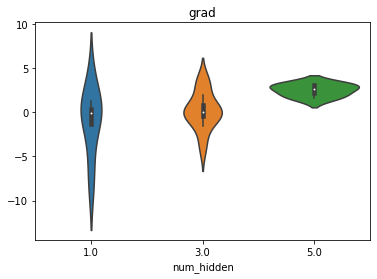

In [15]:
weights_vp(tanh_model2_norm1, att="grad")

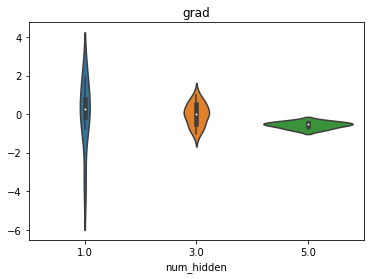

In [16]:
weights_vp(tanh_model2_norm2, att="grad")

# 第一层和第二层的梯度都明显变得平稳
# 能够看出，刚开始时梯度较为平稳，而迭代到后期时就出现了明显的梯度爆炸现象。

#### 3.2 Zero-Centered Data的作用局限

由于各层的梯度实际上受到激活函数、各层输入数据和参数三者共同影响，因此哪怕我们将所有的输入数据都调整为零均值的，各层梯度的计算结果还是有可能因为受到其他因素影响导致不平稳。因此，一味追求输入数据的Zero-Centered或许并不是最好的选择。


### 4.保证梯度平稳的第二条道路：输入数据调整

影响梯度平稳性的核心因素：
- 各层的参数
- 各线性层接收到的数据
- 激活函数

**Batch Normalization：**  
通过修改每一次带入训练的数据分布（每一个Batch）的数据分布，来提升模型各层梯度的平稳性，从而提升模型学习效率、提高模型训练结果。由于是修改每一个Batch的数据分布，因此该方法也被称为小批量数据归一化方法。

## 二、Batch Normalization基础理论

BN方法解决内部协方差偏移（Internal Covariate Shift、ICS）的问题，该问题会导致模型性能下降。

### 1.归一化方法与数据分布的相互独立性

&emsp;&emsp;首先，我们需要知道，任何归一化的本质都是对数据进行平移和放缩
- 平移:数据集每一列统一加上或减去某一个数
  - 在Z-Score中就是每一列减去该列的均值
- 放缩：数据集中每一列数据统一除以或乘以某一个数
  - 在Z-Score中就是每一列除以当前列的标准差
- 数据的平移和放缩，不影响数据特征的分布情况

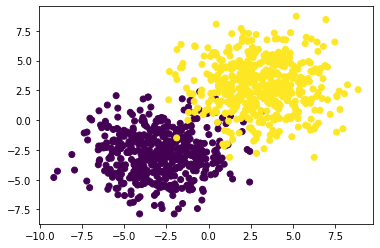

In [17]:
#————————————————————————————创建分类型数据————————————————————————————
# 设置随机数种子
torch.manual_seed(420)   

# 创建数据集
features, labels = tensorGenCla(num_class= 2, deg_dispersion=[6, 2])

# 查看其分布
plt.scatter(features[:, 0], features[:, 1], c = labels)

In [18]:
#————————————————————————————数据归一化————————————————————————————

features

f = Z_ScoreNormalization(features)
f

tensor([[-3.0141, -1.9911],
        [-1.6593, -3.7657],
        [-2.9395, -2.2347],
        ...,
        [ 3.9623,  3.0861],
        [ 1.4535,  0.7860],
        [-1.6681,  4.3935]])

tensor([[-0.8529, -0.5795],
        [-0.4764, -1.0878],
        [-0.8322, -0.6492],
        ...,
        [ 1.0859,  0.8750],
        [ 0.3887,  0.2161],
        [-0.4789,  1.2495]])

<AxesSubplot:>

Text(0.5, 1.0, 'features distribution')

<AxesSubplot:>

Text(0.5, 1.0, 'f distribution')

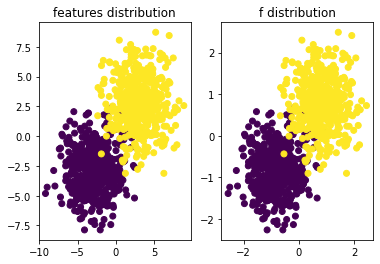

In [19]:
#————————————————————————————归一化前后数据分布————————————————————————————

plt.subplot(121)
plt.scatter(features[:, 0], features[:, 1], c = labels)
plt.title('features distribution')
plt.subplot(122)
plt.scatter(f[:, 0], f[:, 1], c = labels)
plt.title('f distribution')

# 我们发现，归一化前后数据分布不变，但数据在空间中的坐标的绝对值发生变化。
# 当然，我们也可以对原始数据进行任意的平移和放缩，查看是否会改变原数据的分布。

<AxesSubplot:>

Text(0.5, 1.0, 'features distribution')

<AxesSubplot:>

Text(0.5, 1.0, 'f distribution')

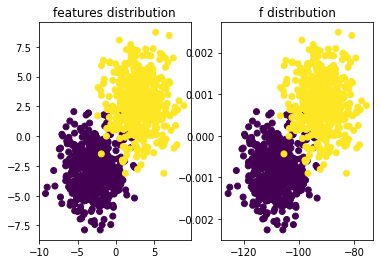

In [20]:
#————————————————————————————进行夸张的平移和放缩————————————————————————————
plt.subplot(121)
plt.scatter(features[:, 0], features[:, 1], c = labels)
plt.title('features distribution')
plt.subplot(122)
plt.scatter(f[:, 0]*10-100, f[:, 1]*0.001, c = labels)
plt.title('f distribution')

# 不改变数据的分布

- 数据归一化不修改数据分布，是我们使用归一化方法的基本前提

### 2.归一化与仿射变换

&emsp;&emsp;归一化的本质仍然是对数据进行仿射变换。根据此前介绍，数据的仿射变换用矩阵形式来进行表示就是：$$\hat x = x * w + b$$其中x是原数据，w是参数矩阵，b是截距，$\hat x$是经过变换之后的数据。此处以Z-Score为例，探讨归一化操作转化为仿射变换的方法。

In [21]:
# 创建一组数据
f = torch.arange(1, 5).reshape(2, 2).float()
f

# 对其进行Z-Score归一化
Z_ScoreNormalization(f)

tensor([[1., 2.],
        [3., 4.]])

tensor([[-0.7071, -0.7071],
        [ 0.7071,  0.7071]])

$$\frac{x-mean(x)}{std(x)}$$

当然，该过程也可以写成如下表达式：

$$\frac{x}{std(x)} - \frac{mean(x)}{std(x)} = x \cdot\frac{1}{std(x)}- \frac{mean(x)}{std(x)} = x \otimes \gamma + \beta$$


其中$\otimes$表示逐个元素相乘，$\gamma 和\beta$为指代参数。

In [22]:
r = torch.tensor(1.) / f.std(0)     # 每列的标准差

In [23]:
rm = torch.diag(r)                  # 构建以每列标准差分之一为对角线元素的对角矩阵
rm

tensor([[0.7071, 0.0000],
        [0.0000, 0.7071]])

In [24]:
torch.mm(f, rm)                     # 计算得出每一列除以标准差之后的结果

tensor([[0.7071, 1.4142],
        [2.1213, 2.8284]])

In [25]:
f / f.std(0)

tensor([[0.7071, 1.4142],
        [2.1213, 2.8284]])

In [26]:
b = -(f.mean(0) / f.std(0))
b

tensor([-1.4142, -2.1213])

In [27]:
torch.mm(f, rm) + b

tensor([[-0.7071, -0.7071],
        [ 0.7071,  0.7071]])

In [28]:
Z_ScoreNormalization(f)

tensor([[-0.7071, -0.7071],
        [ 0.7071,  0.7071]])

在BN中，以每次输入的小批数据为训练数据，我们将平移和放缩的尺度视作参数，通过带入模型进行训练，最终得出最佳平移和放缩尺度，并且这种BN归一化层会可以出现在任意隐藏层的前后，为数据传输的每一步进行归一化操作。

### 3.Batch Normalization基本流程

**BN的平移和放缩分为两个阶段：**
- 第一个阶段是进行Z-Score处理
  - 将输入数据的均值平移至0点，并将输入数据的方差放缩至1
- 第二阶段则是在此基础上在对数据的均值进行参数平移（加上一个通过训练、也就是梯度下降算法算得的参数），并对其方差进行参数（另一个通过模型训练、也就是梯度下降算得的参数）放缩



Stage 1：Z-Score放缩
$$\mu_B = \frac{1}{m_B}\sum^{m_B}_{i=1}x^{(i)}$$
$$\mu_B = \frac{1}{m_B}\sum^{m_B}_{i=1}x^{(i)}$$
$$\hat{x}^{(i)} = \frac{x^{(i)}-\mu_B}{\sqrt{\delta^2_B+\epsilon}}$$

&emsp;&emsp;其中$\mu_B$代表输入的小批数据均值，$\delta^2_B$代表输入的小批数据方差，$\hat{x}$代表Z-Score归一化后的数据结果，和此前一样，Z-Score计算过程为减去每一列的元素减去该列的均值除以该列的修正后的标准差（方差加上一个极小的数使得其不为零）。第一阶段的参数都是可以计算或者人工设置的，其中均值和方差都是简单计算即可得出，而修正项$\epsilon$则是可以手动设置的。

Stage 2：带参数的平移和放缩

$$z^{(i)}=\gamma \otimes \hat{x}^{(i)}+\beta$$
&emsp;&emsp;和第一阶段参数可以简单计算得出不同，二阶段的参数，也就是$\gamma$和$\beta$都是模型参数，在实际模型训练过程中是需要作为模型整体参数的一部分，带入损失函数、进而通过梯度下降计算得出的。

而二阶段的实际处理数据过程，则是首先对一阶段放缩之后每一列的$\hat{x}$乘以一个固定的$\gamma$在加上一个固定的$\beta$。需要强调的是，上述公式是针对列进行处理，即每一列都乘以一个$\gamma$再加上一个$\beta$，并不是所有数据都乘以一个$\gamma$再加上一个$\beta$，也不是每一个数据都乘以一个$\gamma$再加上一个$\beta$。

- BN的两个阶段之间关系

&emsp;&emsp;细心的同学不难发现，实际上BN的第一个阶段和第二个阶段都是在做同一件事——都是在对数据进行平移和放缩，甚至当$\gamma=\sqrt{\delta^2_B+\epsilon}, \beta=\mu_B$，二阶段处理结果将还原回原始输入数据，也就是$z^{(i)}=x^{(i)}$

&emsp;&emsp;既然两个阶段做的相同的事情，为何不能直接合并为一个阶段。从理论上来说，我们可以将上述过程合并为：

$$\begin{aligned}
z^{(i)} 
& = \gamma \otimes \hat{x}^{(i)}+\beta \\
& = \gamma \otimes \frac{x^{(i)}-\mu_B}{\sqrt{\delta^2_B+\epsilon}} + \beta \\
& = \frac{\gamma}{\sqrt{\delta^2_B+\epsilon}}\otimes x^{(i)}+(\beta-\frac{\gamma \cdot \mu_B}{\sqrt{\delta^2_B+\epsilon}}) \\
& = \hat\gamma \otimes {x}^{(i)}+\hat \beta \\
\end{aligned}
$$

&emsp;&emsp;但在实际建模过程中我们并没有这么做，实际PyTorch模型训练完成后输出的参数结果也是原始的$\gamma和\beta$。这里我们可以这样理解：BN方法无疑会增加模型计算量，而提前对数据进行Z-Score处理，就相当于是先选择了一组初始的$\gamma和\beta$对数据进行处理（此时$\gamma_0=\frac{1}{\sqrt{\delta^2_B+\epsilon}}, \beta_0 = \frac{-\mu_B}{\sqrt{\delta^2_B+\epsilon}}$），然后再此基础之上进行带参数的平移和缩放，二阶段平移和缩放的参数是需要经过梯度下降迭代计算得出，而选择在$\gamma_0和\beta_0$基础上进行梯度下降计算，就相当于选择了一组初始值点，而该初始值点能够有效提升迭代收敛速度。